In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [ ]:
df=pd.read_csv("/content/MarketPricePrediction.csv",parse_dates=['date'])

In [ ]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,ABOHAR(PB),January,2005,2350,404,493,446,PB,ABOHAR,2005-01-01
1,ABOHAR(PB),January,2006,900,487,638,563,PB,ABOHAR,2006-01-01
2,ABOHAR(PB),January,2010,790,1283,1592,1460,PB,ABOHAR,2010-01-01
3,ABOHAR(PB),January,2011,245,3067,3750,3433,PB,ABOHAR,2011-01-01
4,ABOHAR(PB),January,2012,1035,523,686,605,PB,ABOHAR,2012-01-01


In [ ]:
# Now We are considereing the as a Regression task we will take all the features that we have for building the model
# 1) Cleaning data and imputing missing values
# 2) Encoding Categorical Features
# 3) Normalizing the Input Features
# 4) Train test Validation Split(As we are not conisdereing this a s time series modelling we will split randomly)
# 5) Build Deep Learning Regression Model
df.columns

Index(['market', 'month', 'year', 'quantity', 'priceMin', 'priceMax',
       'priceMod', 'state', 'city', 'date'],
      dtype='object')

In [ ]:
print("Unique values of Market,State and City Respectively " ,df['market'].nunique(),df['state'].nunique(),df['city'].nunique())

Unique values of Market,State and City Respectively  120 21 117


In [ ]:
import warnings
warnings.filterwarnings("ignore")
markets=df['market'].unique()
cols=["market","date","quantity","priceMin","priceMax","priceMod"]
df_list=[]
for i in markets:
    filtered_df=df[df["market"]==i]
    filtered_df=filtered_df[cols]
    min_date=filtered_df['date'].min()
    max_date=filtered_df['date'].max()
    date_range=pd.date_range(start=min_date,end=max_date,freq="MS")
    filtered_df.set_index("date",drop=True,inplace=True)
    missing_date=date_range[~date_range.isin(filtered_df.index)]
    date_reindexed=filtered_df.reindex(date_range)
    data=date_reindexed.interpolate(method="linear")
    data['market']=data['market'].fillna(data['market'].mode())
    df_list.append(data)
cleaned_df=pd.concat(df_list,axis=0)
cleaned_df['market'].fillna(method="ffill",inplace=True)

In [ ]:
cleaned_df=cleaned_df.reset_index().rename(columns=({"index":"date"}))

In [ ]:
cleaned_df['month']=cleaned_df['date'].dt.month
cleaned_df['year']=cleaned_df['date'].dt.year

In [ ]:
cleaned_df.drop("date",axis=1,inplace=True)

In [ ]:
cleaned_df

,market,quantity,priceMin,priceMax,priceMod,month,year
0,ABOHAR(PB),2350.0,404.0,493.0,446.0,1,2005
1,ABOHAR(PB),1400.0,286.0,365.0,324.0,2,2005
2,ABOHAR(PB),900.0,281.0,357.0,322.0,3,2005
3,ABOHAR(PB),637.5,335.5,453.5,398.5,4,2005
4,ABOHAR(PB),375.0,390.0,550.0,475.0,5,2005
...,...,...,...,...,...,...,...
12429,YEOLA(MS),15593.0,1046.0,3537.0,2886.0,10,2015
12430,YEOLA(MS),62522.0,1003.0,2460.0,1996.0,11,2015
12431,YEOLA(MS),223315.0,609.0,1446.0,1126.0,12,2015
12432,YEOLA(MS),437432.0,437.0,1272.0,1034.0,1,2016


In [ ]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

In [ ]:
encoder=LabelEncoder()
cleaned_df['market']=encoder.fit_transform(cleaned_df['market'])

In [ ]:
X=cleaned_df[['market',"month",	"year","quantity"]]
y=cleaned_df['priceMod']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import numpy as np

# Define the parameter grid
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [int(x) for x in np.linspace(10, 110, num=11)] + [None],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'bootstrap': [True, False]
}

# Initialize the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(),
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=5,  # Number of folds in cross-validation
    scoring='neg_mean_squared_error',  # Use negative mean squared error for evaluation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the data
random_search.fit(X_train, y_train)

# Get the best hyperparameters found
best_params = random_search.best_params_

# Get the best model
best_model = random_search.best_estimator_

# Evaluate the best model
mse = -random_search.best_score_  # Since we used negative mean squared error for evaluation

# Print the results
print("Best Hyperparameters:", best_params)
print("Best MSE:", mse)


In [238]:
best_params

{'bootstrap': False,
 'max_depth': 90,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'n_estimators': 846}

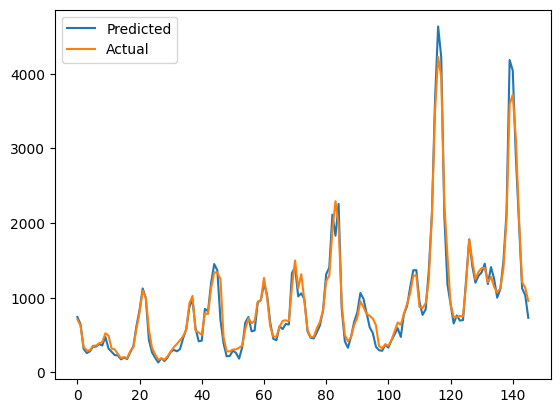

In [243]:
market=["YEOLA(MS)"]
encoded_market=encoder.transform(market)
filtered_test_set=cleaned_df[cleaned_df['market']==encoded_market[0]][['market',"month",	"year","quantity"]]
preds=best_model.predict(filtered_test_set)
actual=cleaned_df[cleaned_df['market']==encoded_market[0]]['priceMod']
plt.plot(actual.values)
plt.plot(preds)
plt.legend(['Predicted',"Actual"])

In [241]:
import pickle

In [260]:
filename="/content/mymodel.pkl"
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)